# Wrangle (Acquire and Prepare)

This notebook contains all steps taken in the data acquisition and preparation phases of the data science pipeline for the Superstore Time Series project. This notebook does rely on helper files so if you want to run the code blocks in this notebook ensure that you have all the helper files in the same directory.

---

## The Required Imports

Everything we need to run the code blocks in this notebook are imported below. To run the code blocks in this report you will need numpy, pandas, matplotlib, seaborn and sklearn installed on your computer.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from _acquire import Acquire

---

## Data Acquisition

In this section we'll cover all the steps taken to acquire the superstore data.

### Reading the Data From the Database

The superstore data is located in the MySQL database hosted at data.codeup.com. We'll need to write a SQL query to select the data.

In [2]:
# We'll need the get_db_url function
from get_db_url import get_db_url

In [3]:
# Here we'll use an SQL query to select the superstore data from data.codeup.com

sql = '''
SELECT
    orders.*,
    Category,
    `Sub-Category`,
    `Customer Name`,
    `Product Name`,
    `Region Name`
FROM orders
JOIN categories USING (`Category ID`)
JOIN customers USING (`Customer ID`)
JOIN products USING (`Product ID`)
JOIN regions USING (`Region ID`);
'''

superstore = pd.read_sql(sql, get_db_url('superstore_db'))
superstore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1734 entries, 0 to 1733
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Order ID       1734 non-null   object 
 1   Order Date     1734 non-null   object 
 2   Ship Date      1734 non-null   object 
 3   Ship Mode      1734 non-null   object 
 4   Customer ID    1734 non-null   object 
 5   Segment        1734 non-null   object 
 6   Country        1734 non-null   object 
 7   City           1734 non-null   object 
 8   State          1734 non-null   object 
 9   Postal Code    1734 non-null   float64
 10  Product ID     1734 non-null   object 
 11  Sales          1734 non-null   float64
 12  Quantity       1734 non-null   float64
 13  Discount       1734 non-null   float64
 14  Profit         1734 non-null   float64
 15  Category ID    1734 non-null   int64  
 16  Region ID      1734 non-null   int64  
 17  Category       1734 non-null   object 
 18  Sub-Cate

### Make it Reproducible

Now that we know how to get the data we need to make the acquisition code reproducible.

In [4]:
# We can inherit the Acquire class to get all the cacheing code. We'll just need to include the code 
# for reading from the database.

class AcquireSuperstore(Acquire):
    def __init__(self):
        self.file_name = 'superstore.csv'
        self.database_name = 'superstore_db'
        self.sql = '''
        SELECT
            orders.*,
            Category,
            `Sub-Category`,
            `Customer Name`,
            `Product Name`,
            `Region Name`
        FROM orders
        JOIN categories USING (`Category ID`)
        JOIN customers USING (`Customer ID`)
        JOIN products USING (`Product ID`)
        JOIN regions USING (`Region ID`);
        '''
        
    def read_from_source(self):
        return pd.read_sql(self.sql, get_db_url(self.database_name))

In [5]:
# Let's test it

superstore = AcquireSuperstore().get_data()
superstore.shape

Reading from .csv file.


(1734, 22)

---

## Data Preparation

Here we'll prepare the data for exploration and modeling. We can see from the info above that the columns need to be renamed for ease of use. Additionally, we'll need to set the order_date to a datetime type and make it the index. Lastly, we'll drop any unneeded columns.

### Cleaning the Columns

Here we'll rename the columns, drop unneeded columns, and set order_date to be the index.

In [6]:
# Here we make all column names lowercase and replace spaces, and dashes, with underscores.

superstore.columns = [column.lower().replace(' ', '_').replace('-','_') for column in superstore]
superstore.columns

Index(['order_id', 'order_date', 'ship_date', 'ship_mode', 'customer_id',
       'segment', 'country', 'city', 'state', 'postal_code', 'product_id',
       'sales', 'quantity', 'discount', 'profit', 'category_id', 'region_id',
       'category', 'sub_category', 'customer_name', 'product_name',
       'region_name'],
      dtype='object')

In [7]:
# Here we'll cast the order_date column to a datetime type.

superstore.order_date = pd.to_datetime(superstore.order_date)
superstore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1734 entries, 0 to 1733
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   order_id       1734 non-null   object        
 1   order_date     1734 non-null   datetime64[ns]
 2   ship_date      1734 non-null   object        
 3   ship_mode      1734 non-null   object        
 4   customer_id    1734 non-null   object        
 5   segment        1734 non-null   object        
 6   country        1734 non-null   object        
 7   city           1734 non-null   object        
 8   state          1734 non-null   object        
 9   postal_code    1734 non-null   float64       
 10  product_id     1734 non-null   object        
 11  sales          1734 non-null   float64       
 12  quantity       1734 non-null   float64       
 13  discount       1734 non-null   float64       
 14  profit         1734 non-null   float64       
 15  category_id    1734 n

In [8]:
# Here we'll set order_date as the index.

superstore = superstore.set_index('order_date').sort_index()
superstore.head()

,order_id,ship_date,ship_mode,customer_id,segment,country,city,state,postal_code,product_id,...,quantity,discount,profit,category_id,region_id,category,sub_category,customer_name,product_name,region_name
order_date,,,,,,,,,,,,,,,,,,,,,
2014-01-04,CA-2014-112326,2014-01-08,Standard Class,PO-19195,Home Office,United States,Naperville,Illinois,60540.0,OFF-LA-10003223,...,3.0,0.2,4.2717,3,3,Office Supplies,Labels,Phillina Ober,Avery 508,Central
2014-01-04,CA-2014-112326,2014-01-08,Standard Class,PO-19195,Home Office,United States,Naperville,Illinois,60540.0,OFF-ST-10002743,...,3.0,0.2,-64.7748,5,3,Office Supplies,Storage,Phillina Ober,SAFCO Boltless Steel Shelving,Central
2014-01-04,CA-2014-112326,2014-01-08,Standard Class,PO-19195,Home Office,United States,Naperville,Illinois,60540.0,OFF-BI-10004094,...,2.0,0.8,-5.4870,9,3,Office Supplies,Binders,Phillina Ober,GBC Standard Plastic Binding Systems Combs,Central
2014-01-09,CA-2014-135405,2014-01-13,Standard Class,MS-17830,Consumer,United States,Laredo,Texas,78041.0,TEC-AC-10001266,...,3.0,0.2,9.7500,12,3,Technology,Accessories,Melanie Seite,Memorex Micro Travel Drive 8 GB,Central
2014-01-09,CA-2014-135405,2014-01-13,Standard Class,MS-17830,Consumer,United States,Laredo,Texas,78041.0,OFF-AR-10004078,...,2.0,0.2,1.1680,7,3,Office Supplies,Art,Melanie Seite,Newell 312,Central


In [9]:
# Here we'll drop all the id columns since these will be useless.
# We'll also drop the postal_code column since it won't be helpful. We can use region to separate the data by
# regions.

superstore.drop(columns=['product_id', 'customer_id', 'region_id', 'category_id', 'order_id', 'postal_code'], inplace=True)
superstore.head()

,ship_date,ship_mode,segment,country,city,state,sales,quantity,discount,profit,category,sub_category,customer_name,product_name,region_name
order_date,,,,,,,,,,,,,,,
2014-01-04,2014-01-08,Standard Class,Home Office,United States,Naperville,Illinois,11.784,3.0,0.2,4.2717,Office Supplies,Labels,Phillina Ober,Avery 508,Central
2014-01-04,2014-01-08,Standard Class,Home Office,United States,Naperville,Illinois,272.736,3.0,0.2,-64.7748,Office Supplies,Storage,Phillina Ober,SAFCO Boltless Steel Shelving,Central
2014-01-04,2014-01-08,Standard Class,Home Office,United States,Naperville,Illinois,3.540,2.0,0.8,-5.4870,Office Supplies,Binders,Phillina Ober,GBC Standard Plastic Binding Systems Combs,Central
2014-01-09,2014-01-13,Standard Class,Consumer,United States,Laredo,Texas,31.200,3.0,0.2,9.7500,Technology,Accessories,Melanie Seite,Memorex Micro Travel Drive 8 GB,Central
2014-01-09,2014-01-13,Standard Class,Consumer,United States,Laredo,Texas,9.344,2.0,0.2,1.1680,Office Supplies,Art,Melanie Seite,Newell 312,Central


In [10]:
# Here we'll drop the ship_date column since it is somewhat redundant.
# There are no null values so we know that each order is shipped. We don't 
# need both dates.

superstore.drop(columns=['ship_date'], inplace=True)

In [11]:
superstore.describe().T

,count,mean,std,min,25%,50%,75%,max
sales,1734.0,229.206358,532.862614,1.0800,16.6950,52.24500,209.91750,8159.952
quantity,1734.0,3.794694,2.297407,1.0000,2.0000,3.00000,5.00000,14.000
discount,1734.0,0.160110,0.206419,0.0000,0.0000,0.20000,0.20000,0.800
profit,1734.0,21.880351,202.891949,-3839.9904,1.7024,8.07305,27.41445,3177.475


### Resampling

Now we will resample the data. We want to make sure there are no gaps in the data. There is a four year span represented in the data so we would expect roughly 4 * 365 = 1460 days to be represented if there aren't any gaps.

In [12]:
# Let's see the unique dates we have.

superstore.index.unique()

DatetimeIndex(['2014-01-04', '2014-01-09', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-16', '2014-01-20', '2014-02-01',
               '2014-02-02', '2014-02-03',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-26',
               '2017-12-28', '2017-12-30'],
              dtype='datetime64[ns]', name='order_date', length=570, freq=None)

We can see here that not every date is present in the data. We only have 570 days represented so there are many gaps in the data. There are too many days missing to upsample so we will need to downsample.

In [13]:
# We will downsample to weeks.

by_week = superstore.resample('W').sum()
by_week

,sales,quantity,discount,profit
order_date,,,,
2014-01-05,288.0600,8.0,1.20,-65.9901
2014-01-12,105.3140,9.0,0.40,36.6531
2014-01-19,1587.2240,34.0,1.50,320.6337
2014-01-26,1859.4000,27.0,0.00,437.2475
2014-02-02,481.2500,11.0,0.00,212.1205
...,...,...,...,...
2017-12-03,7117.5210,113.0,3.20,85.8446
2017-12-10,8637.4830,124.0,4.15,1124.6990
2017-12-17,233.5880,19.0,1.70,-151.0779


For four years there should be roughly 208 weeks represented. We have 209 weeks here so we can safely assume that all weeks are represented in the data.

In [14]:
# We'll just make sure there aren't any null values.

by_week.asfreq("W").isnull().sum()

sales       0
quantity    0
discount    0
profit      0
dtype: int64

### Separating the Data by Region

Now we will want to see if there are differences in sales number between each region represented. We'll need to separate by region name.

In [15]:
# Let's see what regions we have.

superstore.region_name.value_counts()

East       556
West       541
Central    389
South      248
Name: region_name, dtype: int64

In [16]:
# Now let's create dataframes for each region.

supertore_east = superstore[superstore.region_name == "East"]
supertore_west = superstore[superstore.region_name == "West"]
supertore_central = superstore[superstore.region_name == "Central"]
supertore_south = superstore[superstore.region_name == "South"]

We'll need to downsample for each region just like we did for all regions.

In [17]:
# Let's downsample to weeks.

east_by_week = supertore_east.resample('W').sum()
west_by_week = supertore_west.resample('W').sum()
central_by_week = supertore_central.resample('W').sum()
south_by_week = supertore_south.resample('W').sum()

In [18]:
# Let's make sure there aren't any nulls in each region.

west_by_week.asfreq('W').isnull().sum()

sales       0
quantity    0
discount    0
profit      0
dtype: int64

In [19]:
east_by_week.asfreq('W').isnull().sum()

sales       0
quantity    0
discount    0
profit      0
dtype: int64

In [20]:
central_by_week.asfreq('W').isnull().sum()

sales       0
quantity    0
discount    0
profit      0
dtype: int64

In [21]:
south_by_week.asfreq('W').isnull().sum()

sales       0
quantity    0
discount    0
profit      0
dtype: int64

In [22]:
# Now let's see the info for each region.

east_by_week.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 208 entries, 2014-01-12 to 2017-12-31
Freq: W-SUN
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sales     208 non-null    float64
 1   quantity  208 non-null    float64
 2   discount  208 non-null    float64
 3   profit    208 non-null    float64
dtypes: float64(4)
memory usage: 8.1 KB


In [23]:
west_by_week.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 205 entries, 2014-02-02 to 2017-12-31
Freq: W-SUN
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sales     205 non-null    float64
 1   quantity  205 non-null    float64
 2   discount  205 non-null    float64
 3   profit    205 non-null    float64
dtypes: float64(4)
memory usage: 8.0 KB


In [24]:
south_by_week.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 204 entries, 2014-01-12 to 2017-12-03
Freq: W-SUN
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sales     204 non-null    float64
 1   quantity  204 non-null    float64
 2   discount  204 non-null    float64
 3   profit    204 non-null    float64
dtypes: float64(4)
memory usage: 8.0 KB


In [25]:
central_by_week.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 209 entries, 2014-01-05 to 2017-12-31
Freq: W-SUN
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sales     209 non-null    float64
 1   quantity  209 non-null    float64
 2   discount  209 non-null    float64
 3   profit    209 non-null    float64
dtypes: float64(4)
memory usage: 8.2 KB


We can see that each region has different start and end dates. We'll keep this in mind in case we need to fill in those missing dates.

### Separating the Data by Product Category

We will want to see how sales numbers vary between different product categories. We'll separate the data by category here.

In [26]:
# Let's see the different categories we have.

superstore.category.value_counts()

Office Supplies    1055
Furniture           360
Technology          319
Name: category, dtype: int64

In [27]:
# Now let's create dataframes for each category.

office_supplies = superstore[superstore.category == 'Office Supplies']
furniture = superstore[superstore.category == 'Furniture']
technology = superstore[superstore.category == 'Technology']

In [28]:
# Let's downsample to weeks.

office_supplies_by_week = office_supplies.resample('W').sum()
furniture_by_week = furniture.resample('W').sum()
technology_by_week = technology.resample('W').sum()

In [29]:
# Let's check the info for each category.

office_supplies_by_week.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 209 entries, 2014-01-05 to 2017-12-31
Freq: W-SUN
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sales     209 non-null    float64
 1   quantity  209 non-null    float64
 2   discount  209 non-null    float64
 3   profit    209 non-null    float64
dtypes: float64(4)
memory usage: 8.2 KB


In [30]:
furniture_by_week.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 208 entries, 2014-01-12 to 2017-12-31
Freq: W-SUN
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sales     208 non-null    float64
 1   quantity  208 non-null    float64
 2   discount  208 non-null    float64
 3   profit    208 non-null    float64
dtypes: float64(4)
memory usage: 8.1 KB


In [31]:
technology_by_week.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 208 entries, 2014-01-12 to 2017-12-31
Freq: W-SUN
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sales     208 non-null    float64
 1   quantity  208 non-null    float64
 2   discount  208 non-null    float64
 3   profit    208 non-null    float64
dtypes: float64(4)
memory usage: 8.1 KB


We can see that most weeks are represented for each category.

### Make it Reproducible

Now we need to put all the steps above into a reusable function. This function will be in the prepare.py file.

In [32]:
# We'll test out the prepare function to make sure it works.
# It will return 5 dataframes.

from prepare import prepare

In [33]:
dfs = prepare(AcquireSuperstore().get_data())

Reading from .csv file.


In [34]:
dfs[0].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 209 entries, 2014-01-05 to 2017-12-31
Freq: W-SUN
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sales     209 non-null    float64
 1   quantity  209 non-null    float64
 2   discount  209 non-null    float64
 3   profit    209 non-null    float64
dtypes: float64(4)
memory usage: 8.2 KB


In [35]:
dfs[1].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 208 entries, 2014-01-12 to 2017-12-31
Freq: W-SUN
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sales     208 non-null    float64
 1   quantity  208 non-null    float64
 2   discount  208 non-null    float64
 3   profit    208 non-null    float64
dtypes: float64(4)
memory usage: 8.1 KB


In [36]:
dfs[2].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 205 entries, 2014-02-02 to 2017-12-31
Freq: W-SUN
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sales     205 non-null    float64
 1   quantity  205 non-null    float64
 2   discount  205 non-null    float64
 3   profit    205 non-null    float64
dtypes: float64(4)
memory usage: 8.0 KB


In [37]:
dfs[3].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 209 entries, 2014-01-05 to 2017-12-31
Freq: W-SUN
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sales     209 non-null    float64
 1   quantity  209 non-null    float64
 2   discount  209 non-null    float64
 3   profit    209 non-null    float64
dtypes: float64(4)
memory usage: 8.2 KB


In [38]:
dfs[4].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 204 entries, 2014-01-12 to 2017-12-03
Freq: W-SUN
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sales     204 non-null    float64
 1   quantity  204 non-null    float64
 2   discount  204 non-null    float64
 3   profit    204 non-null    float64
dtypes: float64(4)
memory usage: 8.0 KB


In [39]:
dfs[5].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 209 entries, 2014-01-05 to 2017-12-31
Freq: W-SUN
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sales     209 non-null    float64
 1   quantity  209 non-null    float64
 2   discount  209 non-null    float64
 3   profit    209 non-null    float64
dtypes: float64(4)
memory usage: 8.2 KB


In [40]:
dfs[6].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 208 entries, 2014-01-12 to 2017-12-31
Freq: W-SUN
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sales     208 non-null    float64
 1   quantity  208 non-null    float64
 2   discount  208 non-null    float64
 3   profit    208 non-null    float64
dtypes: float64(4)
memory usage: 8.1 KB


In [41]:
dfs[7].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 208 entries, 2014-01-12 to 2017-12-31
Freq: W-SUN
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sales     208 non-null    float64
 1   quantity  208 non-null    float64
 2   discount  208 non-null    float64
 3   profit    208 non-null    float64
dtypes: float64(4)
memory usage: 8.1 KB


It all looks good.

---

## Splitting the Data

Finally we need to make a function that will split the data for us.

### How to do the Split?

First we need to figure out how we want to split the data.

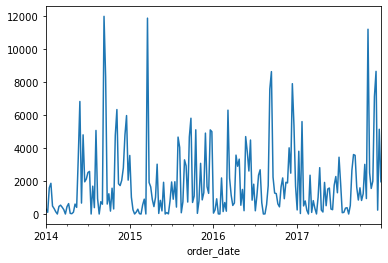

In [42]:
by_week.sales.plot();

We have four years in the data so we can split by year to make things simple and intuitive.

In [43]:
train = by_week.loc[ : '2015']
validate = by_week.loc['2016']
test = by_week.loc['2017']

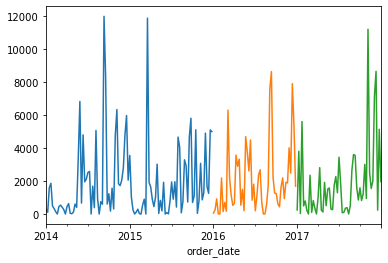

In [44]:
train.sales.plot()
validate.sales.plot()
test.sales.plot();

### Make it Reproducible

Now let's put it in a function.

In [45]:
from prepare import split_data

In [46]:
# Let's test it

train, validate, test = split_data(by_week)

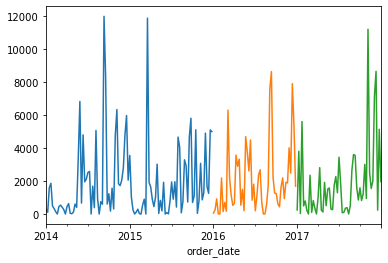

In [47]:
train.sales.plot()
validate.sales.plot()
test.sales.plot();

It works!

---

## Removing Outliers

One more thing we want to try is removing outliers. We can see from the spikes in the data above that there are some outliers that may be skewing the data. We want to try to remove these outliers to see if this can provide clearer patterns in the data and we can investigate the outliers separately.

In [48]:
# Here we'll import a remove_outliers function

from prepare import remove_outliers

In [50]:
superstore_no_outliers = remove_outliers(superstore, 1.5, ['sales'])
superstore_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1523 entries, 2014-01-04 to 2017-12-30
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ship_mode      1523 non-null   object 
 1   segment        1523 non-null   object 
 2   country        1523 non-null   object 
 3   city           1523 non-null   object 
 4   state          1523 non-null   object 
 5   sales          1523 non-null   float64
 6   quantity       1523 non-null   float64
 7   discount       1523 non-null   float64
 8   profit         1523 non-null   float64
 9   category       1523 non-null   object 
 10  sub_category   1523 non-null   object 
 11  customer_name  1523 non-null   object 
 12  product_name   1523 non-null   object 
 13  region_name    1523 non-null   object 
dtypes: float64(4), object(10)
memory usage: 178.5+ KB


In [53]:
by_week = superstore_no_outliers.resample('W').sum()
by_week

,sales,quantity,discount,profit
order_date,,,,
2014-01-05,288.0600,8.0,1.20,-65.9901
2014-01-12,105.3140,9.0,0.40,36.6531
2014-01-19,367.9040,22.0,1.50,27.5829
2014-01-26,91.5300,17.0,0.00,30.9983
2014-02-02,481.2500,11.0,0.00,212.1205
...,...,...,...,...
2017-12-03,2285.5810,83.0,2.30,380.4204
2017-12-10,2554.1140,94.0,3.60,427.3692
2017-12-17,233.5880,19.0,1.70,-151.0779


We can put this remove outliers preparation into a separate function for analysis.